### Reproduce Figure 2 in Vecellio et al 2023


In [5]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from cartopy import config
from cartopy.io import shapereader
from geopy.geocoders import Nominatim
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [7]:
# read city information
CITIES=pd.read_excel('./data/CITIES.xlsx')

df=CITIES.copy()
drop_cities=['Jaipur','Ibadan','Hangzhou',"Xi'an",'Jinan']
for drop_city in drop_cities:
    drop_index=CITIES[CITIES['Cities'] == drop_city].index
    df=df.drop(labels=drop_index, axis=0)

In [31]:
def read_hothours(X):
    # read hot-hours data for +XC warming compared with preindustrial period
    path='./data/Tw_tot_hothours_preindustrial_'+str(X)+'C.nc'
    result=xr.open_dataset(path).hours
    return result

# read hot-hours data for 1.5, 2, 3, 4C degree warming compared with preindustrial period
hothours={}
for X in [1.5,2,3,4]:
    tmp=read_hothours(X)*3 # multiply 3 since the original hot-hours are calculated from 3-hourly data
    hothours[X]=tmp
hothours=xr.concat(list(hothours.values()),dim='X')
hothours['X']=[1.5,2,3,4]

In [10]:
color=np.array([
    [225,225,225],
    [255, 245, 204],
    [255, 230, 112],
    [255, 204,  51],
    [255, 175,  51],
    [255, 153,  51],
    [255, 111,  51],
    [255,  85,   0],
    [230,  40,  30],
    [200,  30,  20]])

cmap=mpl.colors.ListedColormap(color/255.)

In [11]:
# interpolate NaN values around 0E
def interp(data):
    data2=data.copy()
    longitude=data.lon
    longitude=xr.where(longitude>180,longitude-360,longitude)
    data2['lon']=longitude
    data2=data2.sortby('lon')
    loc=0
    locnew=np.array([loc-1,loc-0.75,loc-0.5,loc-0.25,loc,loc+0.25,loc+0.5,loc+0.75,loc+1])
    tmp=data2.drop_sel(lon=locnew)
    tmp2=tmp.interp(lon=data2.lon.values)
    longitude2=tmp2.lon
    longitude2=xr.where(longitude2<0,longitude2+360,longitude2)
    tmp2['lon']=longitude2
    return tmp2.sortby('lon')

In [12]:
# define regions lat-lon range
region_names=['South Asia', 'East Asia', 'Africa', 'Middle East', 'North America']
lat_lon={'East Asia': {'lat1':7,
                       'lat2':56,
                       'lon1':100,
                       'lon2':137},
         'South Asia':{'lat1':7,
                       'lat2':35,
                       'lon1':63,
                       'lon2':95},
         'North America':{'lat1':10,
                          'lat2':48,
                          'lon1':-120,
                          'lon2':-77},
         'Africa':{'lat1':-3,
                   'lat2':25,
                   'lon1':-15,
                   'lon2':30},
         'Middle East':{'lat1':8,
                        'lat2':36,
                        'lon1':35,
                        'lon2':60}
        }

In [13]:
# adjust the position of the labels for certain cities on the map
adjust_cities=['Faisalabad','Karachi','Kolkata','Multan','Chattogram','Guangzhou','Chongqing','Changsha',
              'Shanghai','Hangzhou','Beijing','Nanjing','Tianjin','Osaka','Ha Noi','Philadelphia','Houston',
              'Chicago','Cartagena','Dubai','Mecca','Aden','Basra','Dammam','Khartoum',
              'Kumasi','Lome','Lagos','Bandar Abbas','Wuhan','Tokyo','New York','Detroit','Busan']
lat_offsets={'Faisalabad':-0.5,'Karachi':-1.25,'Kolkata':0,'Chattogram':-0.8,'Guangzhou':0.2,
         'Chongqing':-2,'Changsha':-1.7,'Shanghai':0,'Hangzhou':-0.3,'Beijing':0.15,
         'Tianjin':-1.5,'Osaka':-1,'Ha Noi':0.15,'Philadelphia':-0.5,'Houston':0.5,
         'Chicago':-0.5,'Cartagena':-0.6,'Dubai':0.25,'Mecca':-0.6,'Aden':-0.6,'Basra':0.18,
         'Dammam':0,'Khartoum':2.5,'Kumasi':0.2,'Lome':-1.6,'Multan':-0.6,'Lagos':-0.2,
            'Nanjing':0.15,'Bandar Abbas':0.5,'Wuhan':-1.5,'Tokyo':1,'New York':1.6,'Detroit':1.3,'Busan':0.2}
lon_offsets={'Faisalabad':-8,'Karachi':-4.5,'Kolkata':-4.5,'Chattogram':-1,'Guangzhou':-1,
         'Chongqing':-5,'Changsha':-5,'Shanghai':0.5,'Hangzhou':0.3,'Beijing':-6,
         'Tianjin':-5,'Osaka':0.3,'Ha Noi':-1.5,'Philadelphia':-6,'Houston':-3.3,
         'Chicago':-9,'Cartagena':0.15,'Dubai':-2.8,'Mecca':0.15,'Aden':0.15,'Basra':-3.2,
         'Dammam':-5.3,'Khartoum':-9,'Kumasi':-3,'Lome':-2,'Multan':0.3,'Lagos':0.3,
            'Nanjing':-6,'Bandar Abbas':-4,'Wuhan':0,'Tokyo':-3,'New York':-4,'Detroit':-8,'Busan':-3}


In [27]:
landmask= regionmask.defined_regions.natural_earth.land_110.mask(hothours,lon_name="lon",lat_name="lat")

def plot_cities(ax,region,add_cities):
    # plot city dots with annotation, finalize plot
    # lat/lon coordinates of five cities in Bangladesh
    countries=region.Countries.values
    cities=region.Cities.values
    region_name=region.Regions.values[0]
    geolocator = Nominatim(user_agent='myapplication')
    for k in range(len(countries)):
        city = cities[k]
        country=countries[k]
        location = geolocator.geocode(city+', '+country)
        if region_name=='South America':
            lon=location.longitude+360
        else:
            lon=location.longitude
        lat=location.latitude
        if city in adjust_cities:
            lon_offset=lon_offsets[city]
            lat_offset=lat_offsets[city]
        else:
            lon_offset=0.15
            lat_offset=0.15
        ax.plot(lon, lat, "ko", ms=3,alpha=0.7, transform=ccrs.PlateCarree())
        if add_cities:
            ax.text(lon + lon_offset, lat + lat_offset, city, fontsize="small",alpha=0.7, transform=ccrs.PlateCarree())
def subplot_region(data,axis,norm,cmap,lat_lon,region,add_cities):
    region_name=region.Regions.values[0]
    if region_name =='Africa':
        tmp=data.pipe(interp).where(landmask==0)
    else:
        tmp=data.where(landmask==0)
    LON,LAT=np.meshgrid(tmp.lon.values,tmp.lat.values)
    
        
    g=axis.pcolormesh(LON, LAT,tmp,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    axis.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='50m', #1:50million; three options: 10m, 50m, 110m
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
    fpath = config['data_dir'] + r'/shapefiles/natural_earth/physical/ne_50m_lakes.shp'
    as_shp = shapereader.Reader( fpath )
    Great_lakes=['Lake Erie','Lake Ontario','Lake Michigan','Lake Superior','Lake Huron']    
    for rec in as_shp.records():
        if rec.attributes['name']  in Great_lakes:
            axis.add_geometries( [rec.geometry], ccrs.PlateCarree(), edgecolor='none', facecolor='white' )
    pass
    axis.add_feature(cfeature.RIVERS.with_scale('50m'),alpha=0.7)
    plot_cities(axis,region,add_cities)

    axis.coastlines(linewidth=0.5,resolution='10m') # add coastlines
    axis.set_title('')
    axis.set_extent([lat_lon['lon1'],lat_lon['lon2'],lat_lon['lat1'],lat_lon['lat2']])
    return g


def plot_each_region(data,region,region_name,lat_lon):
    levels=[0,3,8,24,56,112,168,240,480,720]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels),extend='max')
    fig = plt.figure(figsize=(15,18))
    Xs=[1.5,2,3,4]
    anno_opts = dict(xy=(0.02, 0.9), xycoords='axes fraction',va='baseline', ha='left')
    annots={'South Asia':['a', 'b', 'c', 'd'],
            'East Asia':['e', 'f', 'g', 'h'],
            'Africa':['i', 'j', 'k', 'l'],
            'Middle East': ['m', 'n', 'o', 'p'],
            'North America':['q', 'r', 's', 't']
           }
    
    anno_opts2 = dict(xy=(0.37, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    annots2=['+$1.5^\circ$C','+$2^\circ$C','+$3^\circ$C','+$4^\circ$C']

    center_lat=(lat_lon[region_name]['lat1']+lat_lon[region_name]['lat2'])/2
    center_lon=(lat_lon[region_name]['lon1']+lat_lon[region_name]['lon2'])/2
    for j in range(4):
        add_cities=True if j==3 else False
        tmp=data.sel(X=Xs[j])
        if region_name=='South America':
            ax = fig.add_subplot(1,4,j+1,projection=ccrs.LambertCylindrical(central_longitude=center_lon))
        else:
            ax = fig.add_subplot(1,4,j+1,projection=ccrs.LambertConformal(central_longitude=center_lon,central_latitude=center_lat,cutoff=-60))
        g=subplot_region(tmp,ax,norm,cmap,
                         lat_lon[region_name],region,add_cities)
        ax.annotate(annots[region_name][j], **anno_opts,fontsize=24)
        ax.annotate(annots2[j], **anno_opts2,fontsize=24)
    fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0,wspace=0)
    axs=fig.get_axes()
    if region_name=='North America':
        cb=fig.colorbar(g,ax=axs,orientation='horizontal',pad=0.04,shrink=0.75,fraction=.08,aspect=50,ticks=levels)
        cb.set_label(label='Annual hot hours', size=14)
        cb.ax.tick_params(labelsize=12)


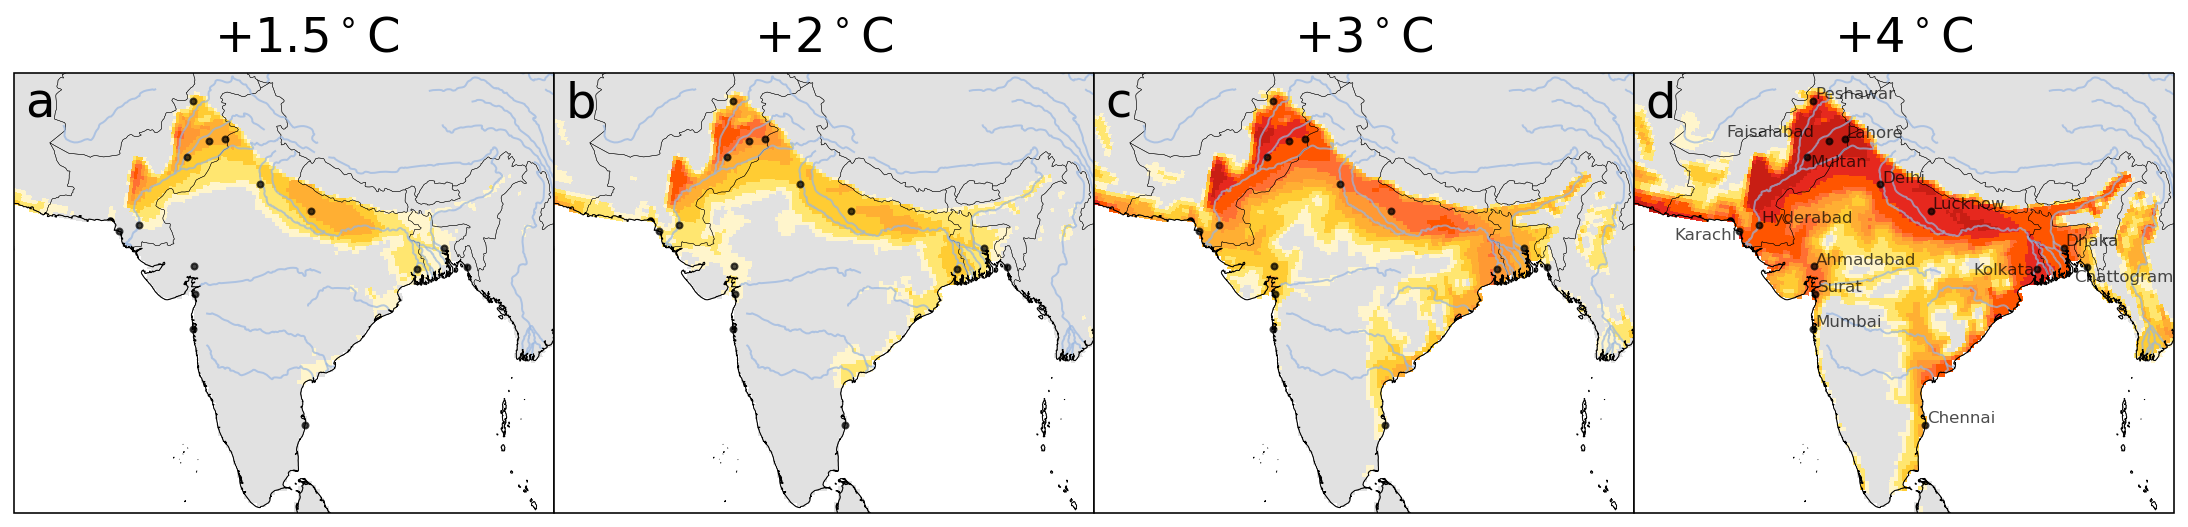

In [18]:
# plot South Asia
plot_each_region(hothours,df.loc[df.Regions=='South Asia'],'South Asia',lat_lon)

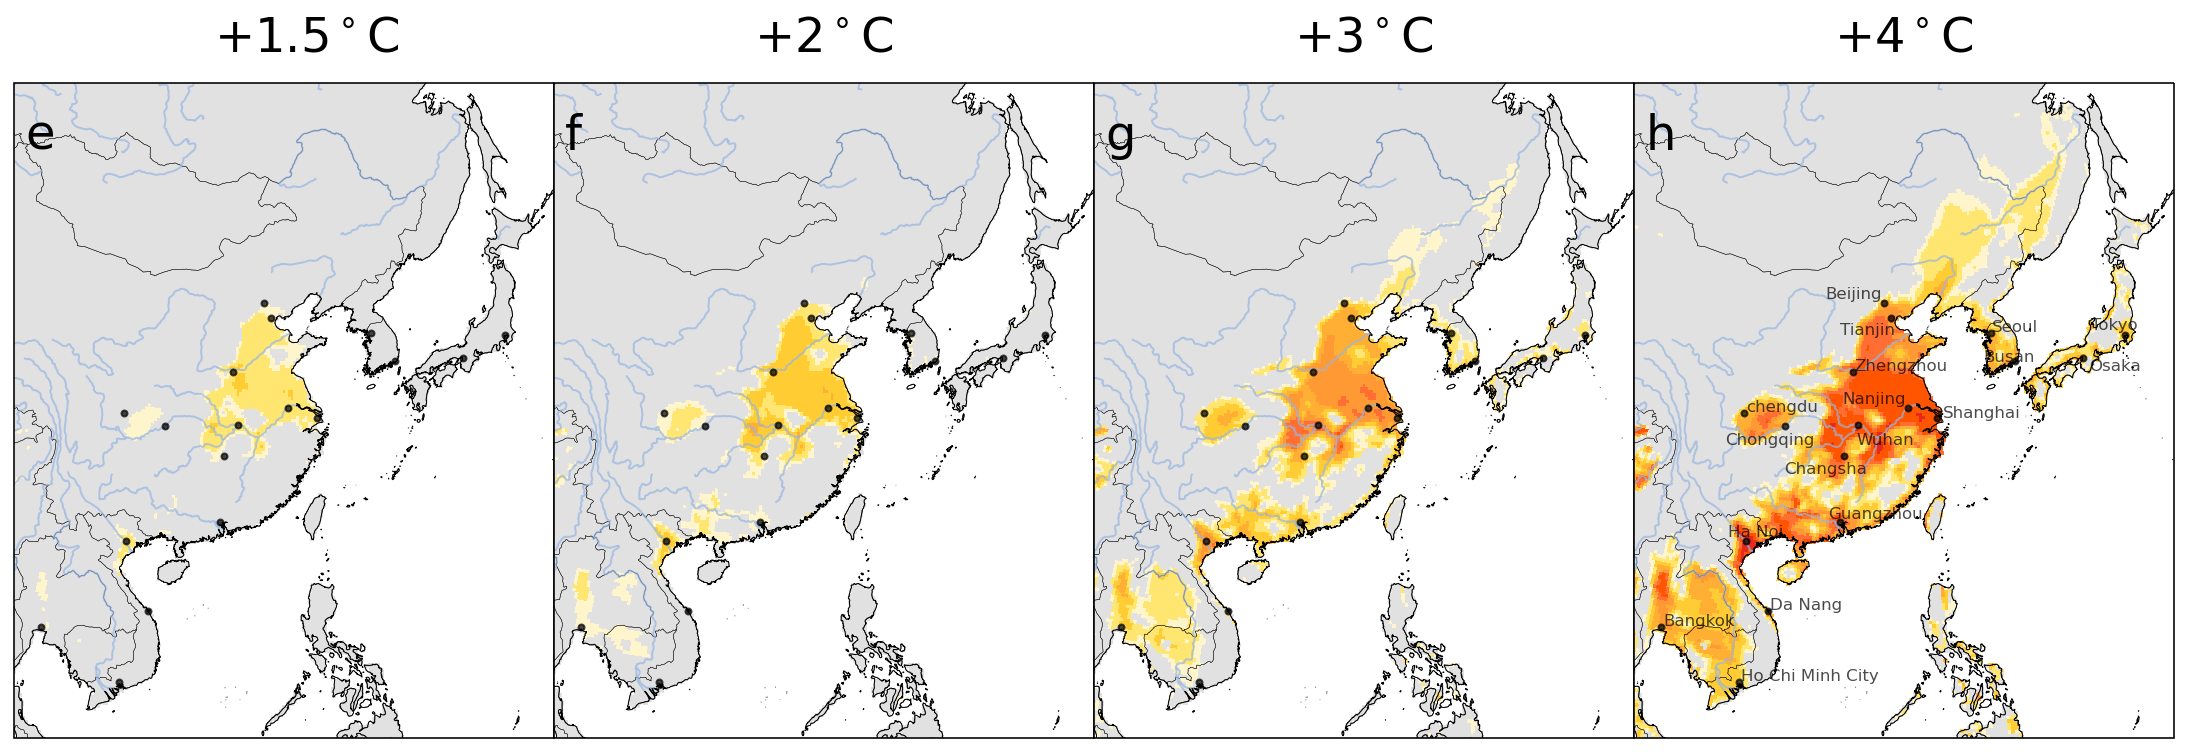

In [19]:
# plot East Asia
plot_each_region(hothours,df.loc[df.Regions=='East Asia'],'East Asia',lat_lon)

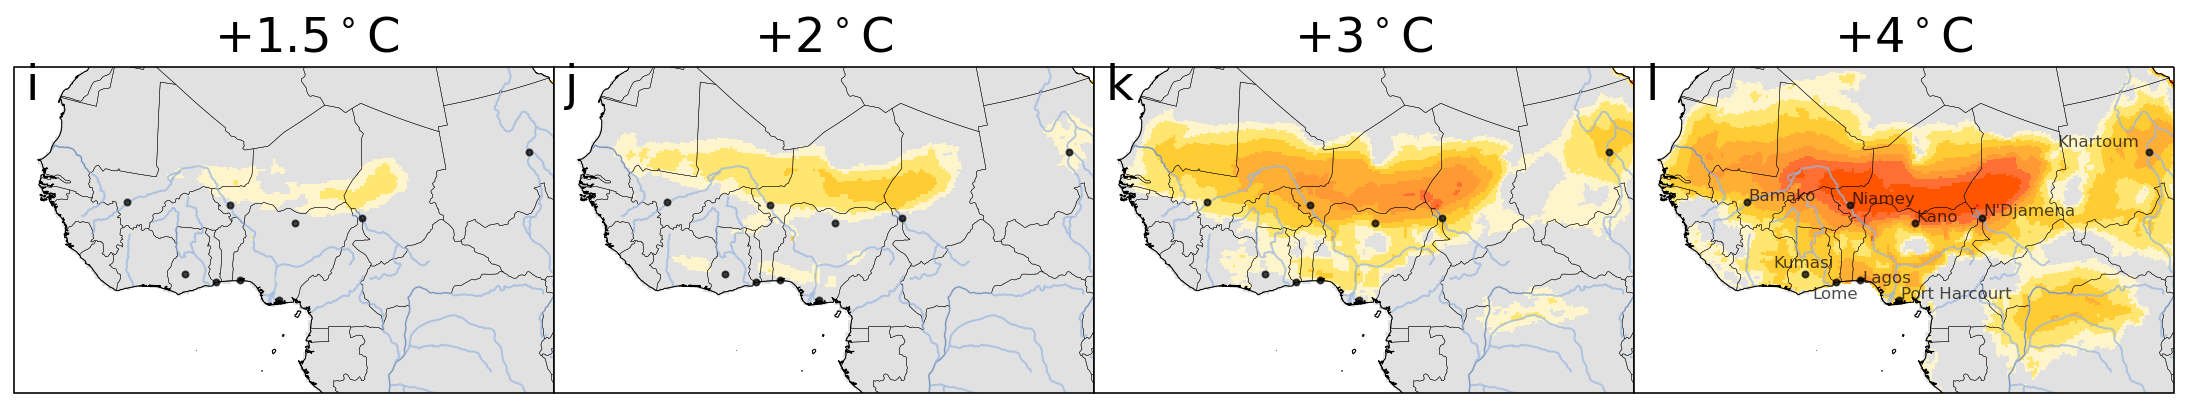

In [23]:
# plot Africa
plot_each_region(hothours,df.loc[df.Regions=='Africa'],'Africa',lat_lon)

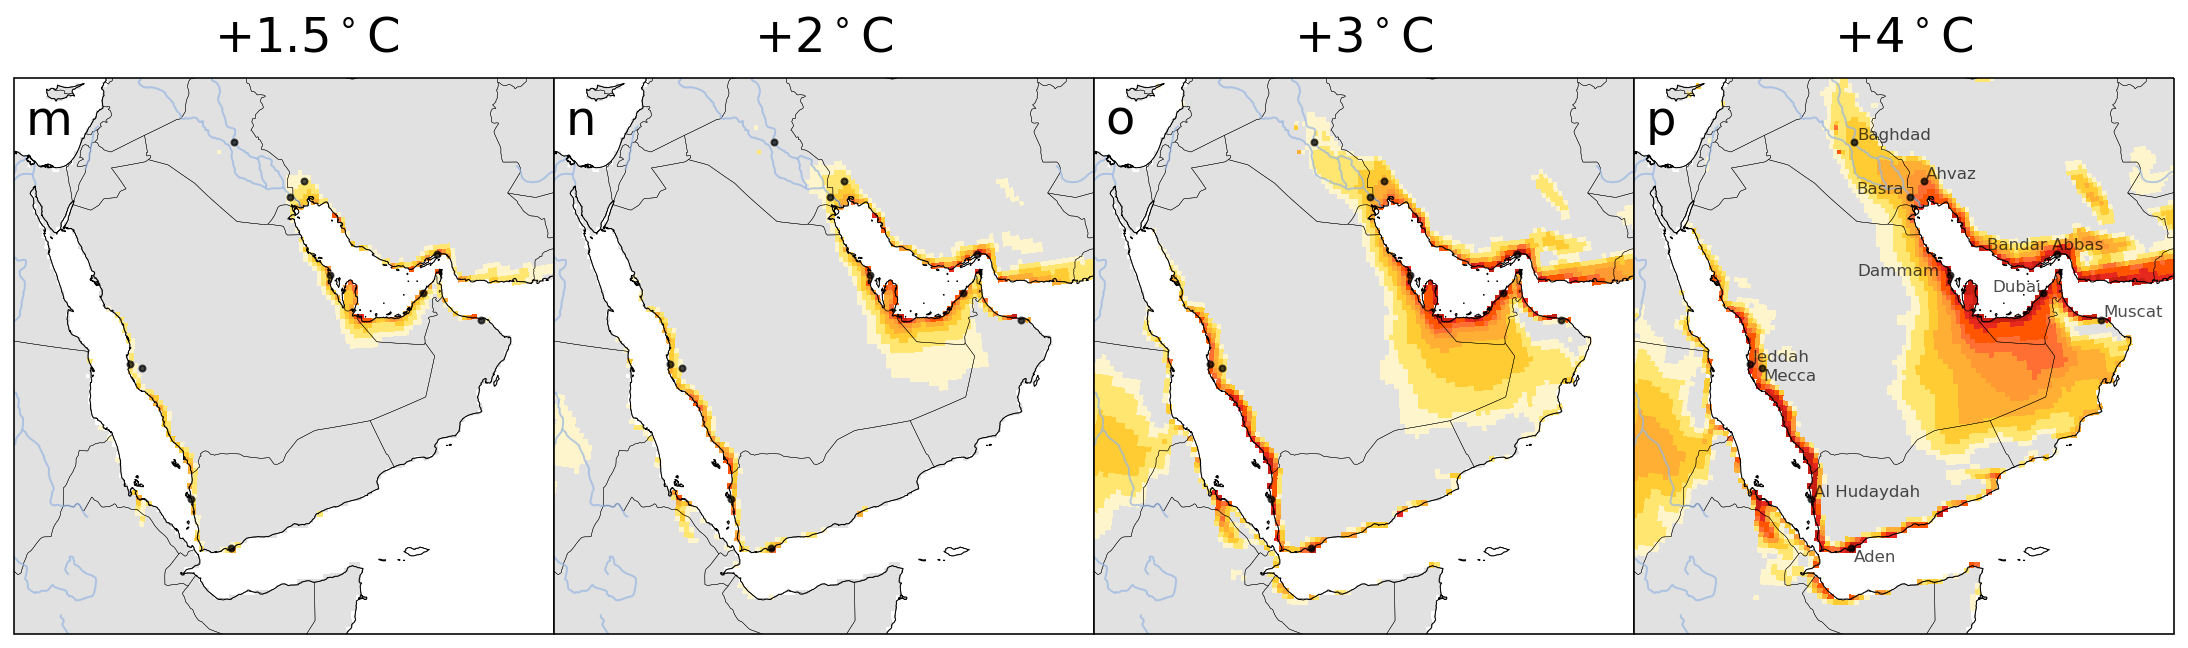

In [24]:
# plot Middle East
plot_each_region(hothours,df.loc[df.Regions=='Middle East'],'Middle East',lat_lon)

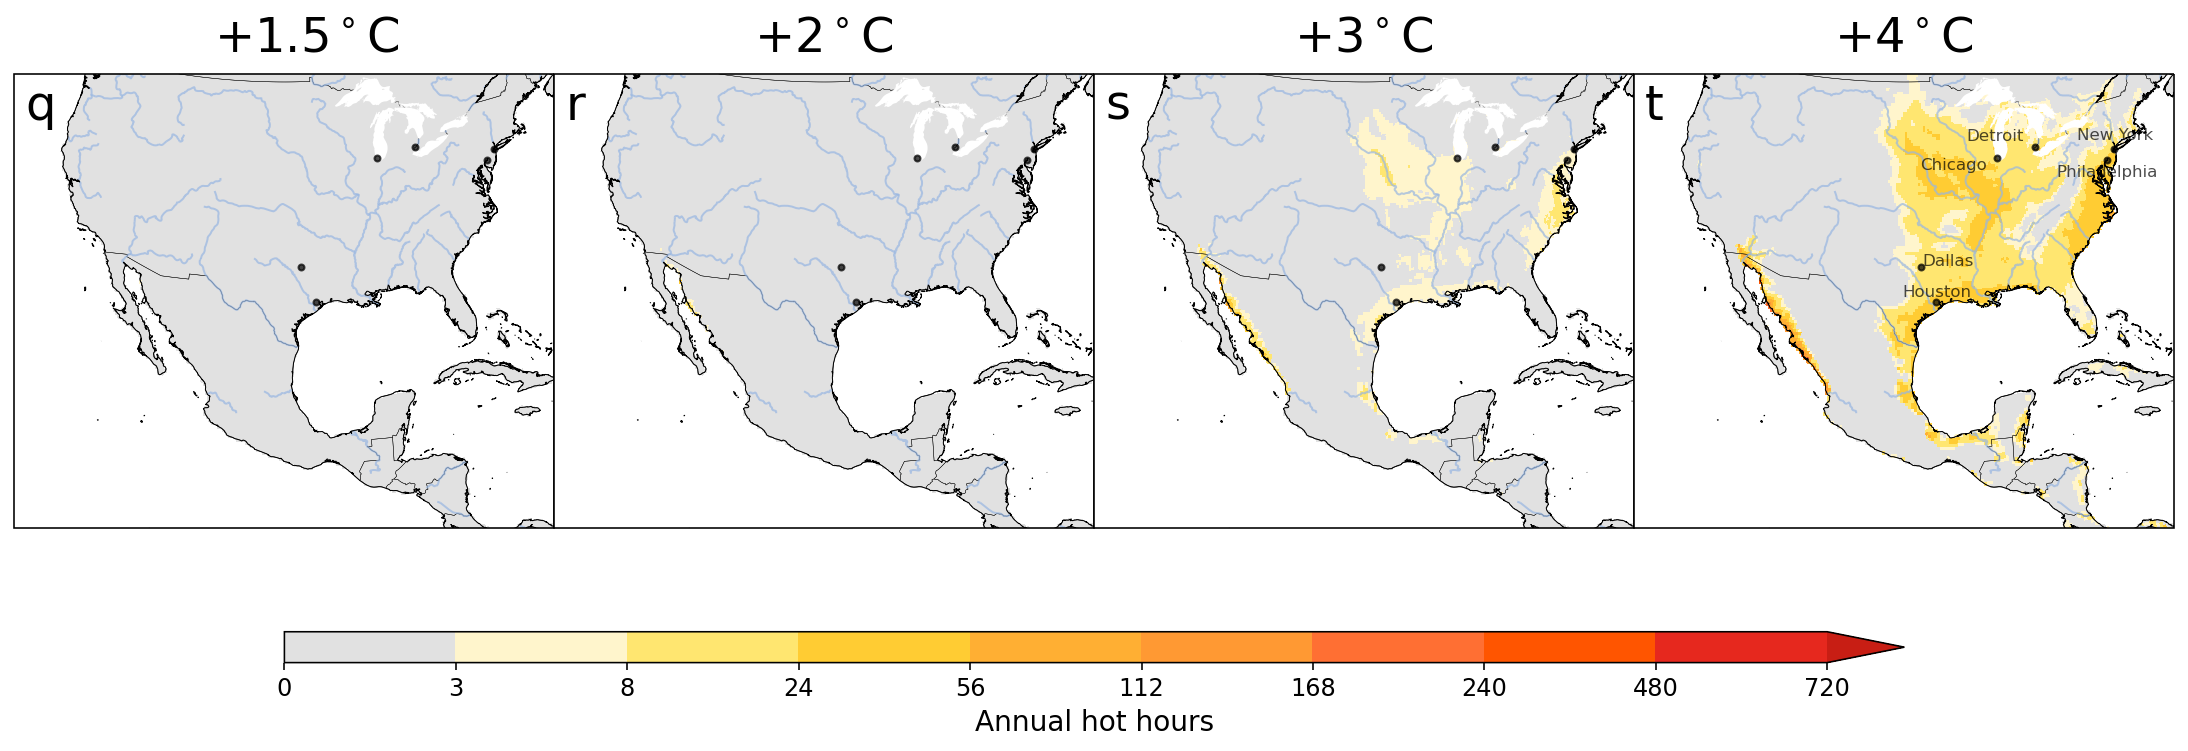

In [28]:
# plot North America
plot_each_region(hothours,df.loc[df.Regions=='North America'],'North America',lat_lon)